### Natural Language Processing  - Syntactic Analysis - HMMs and Viterbi algorithm for POS tagging
- Naresh Dogra 
- Upgrad Cohort 2018

### Problem Statement:
You need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

1) Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.

2) Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?
 

You have been given a 'test' file below containing some sample sentences with unknown words. Look at the sentences and try to observe rules which may be useful to tag unknown words. Your final model will be evaluated on a similar test file.

##### Data
For this assignment, you’ll use the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK (https://www.nltk.org/_modules/nltk/tag/mapping.html) comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.

Note that using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

##### Goals
You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

You need to accomplish the following in this assignment:

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## POS tagging using modified Viterbi

### Data Preparation

In [2386]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from pathlib import Path
from nltk.tag import RegexpTagger

In [2387]:
folder = Path('C:/Upgrad Projects/NLP-M1/Assignment')

In [2388]:
#nltk.download('universal_tagset')

In [2389]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [2390]:
len(nltk_data)

3914

In [2391]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))

3718
196


In [2392]:
# Getting list of tagged words in Train set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95474

In [2393]:
# Getting list of tagged words in Test set
test_tagged_words = [tup for sent in test_set for tup in sent]
len(test_tagged_words)

5202

In [2394]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]

In [2395]:
# vocabulary
V = set(tokens)
print(len(V))

12055


In [2396]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [2397]:
T

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

### Build the vanilla Viterbi based POS tagger

In [2398]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
print('t = ', t)
print('v = ', v)
w_given_t = np.zeros((t, v))
print(w_given_t)
w_given_t.shape

t =  12
v =  12055
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


(12, 12055)

In [2399]:
### Emission Probabilities
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [2400]:
### Transition Probabilities
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [2401]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [2402]:
tags_matrix

array([[  4.63392033e-04,   1.19091749e-01,   5.97775728e-02,
          3.66079696e-02,   5.56070432e-02,   5.32900840e-02,
          4.63392027e-03,   4.17052843e-02,   7.87766464e-03,
          1.51992589e-01,   1.17701575e-01,   3.51251155e-01],
       [  1.69463642e-02,   6.74564019e-02,   4.93583444e-04,
          6.53175414e-02,   4.60677873e-03,   7.74925947e-02,
          1.11878905e-02,   2.07305029e-02,   2.07305029e-02,
          1.21750580e-02,   5.10036200e-03,   6.97762430e-01],
       [  4.99999989e-03,   7.34615400e-02,   8.07692297e-03,
          4.11538444e-02,   3.38461548e-02,   2.03846153e-02,
          1.19230766e-02,   7.69230770e-03,   9.00000036e-02,
          4.86538470e-01,   9.61538497e-03,   2.12307692e-01],
       [  5.85634373e-02,   4.38548997e-02,   6.63237646e-02,
          9.19509083e-02,   5.35101965e-02,   9.15899649e-02,
          2.43638339e-03,   8.12127739e-02,   2.72513982e-02,
          8.87024030e-02,   1.73614874e-01,   2.20898747e-01],
    

In [2403]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [2404]:
tags_df

,CONJ,ADJ,PRON,.,ADV,ADP,PRT,NUM,X,VERB,DET,NOUN
CONJ,0.000463,0.119092,0.059778,0.036608,0.055607,0.053290,0.004634,0.041705,0.007878,0.151993,0.117702,0.351251
ADJ,0.016946,0.067456,0.000494,0.065318,0.004607,0.077493,0.011188,0.020731,0.020731,0.012175,0.005100,0.697762
PRON,0.005000,0.073462,0.008077,0.041154,0.033846,0.020385,0.011923,0.007692,0.090000,0.486538,0.009615,0.212308
.,0.058563,0.043855,0.066324,0.091951,0.053510,0.091590,0.002436,0.081213,0.027251,0.088702,0.173615,0.220899
ADV,0.007390,0.130668,0.014780,0.136715,0.077595,0.119919,0.014780,0.031240,0.022842,0.342291,0.067854,0.033927
ADP,0.001071,0.106638,0.069700,0.040043,0.013704,0.016702,0.001392,0.062634,0.034047,0.008565,0.324304,0.321199
PRT,0.002288,0.084995,0.017653,0.042498,0.009807,0.020922,0.001961,0.058516,0.013076,0.401111,0.101013,0.246159
NUM,0.013263,0.033893,0.001474,0.115532,0.002947,0.035072,0.027704,0.187445,0.209254,0.017389,0.002947,0.353080
X,0.010193,0.017359,0.056219,0.162606,0.025641,0.145883,0.183946,0.002707,0.074693,0.204332,0.054627,0.061793
VERB,0.005059,0.065613,0.035181,0.034714,0.080402,0.090286,0.031522,0.023583,0.219100,0.169521,0.135118,0.109900


In [2405]:
tags_df.loc['.', :]

CONJ    0.058563
ADJ     0.043855
PRON    0.066324
.       0.091951
ADV     0.053510
ADP     0.091590
PRT     0.002436
NUM     0.081213
X       0.027251
VERB    0.088702
DET     0.173615
NOUN    0.220899
Name: ., dtype: float32

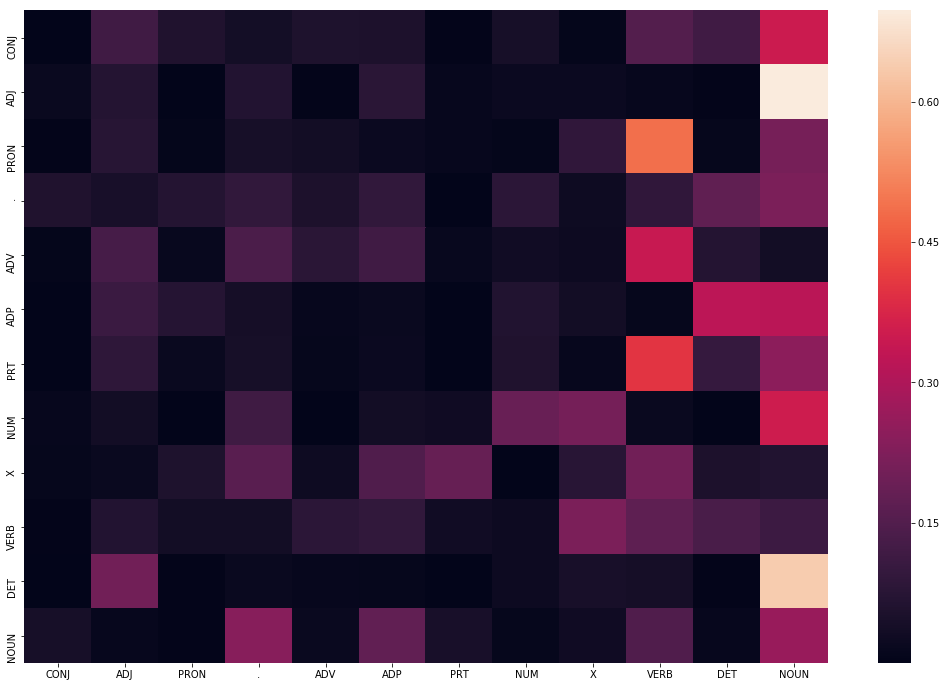

In [2406]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

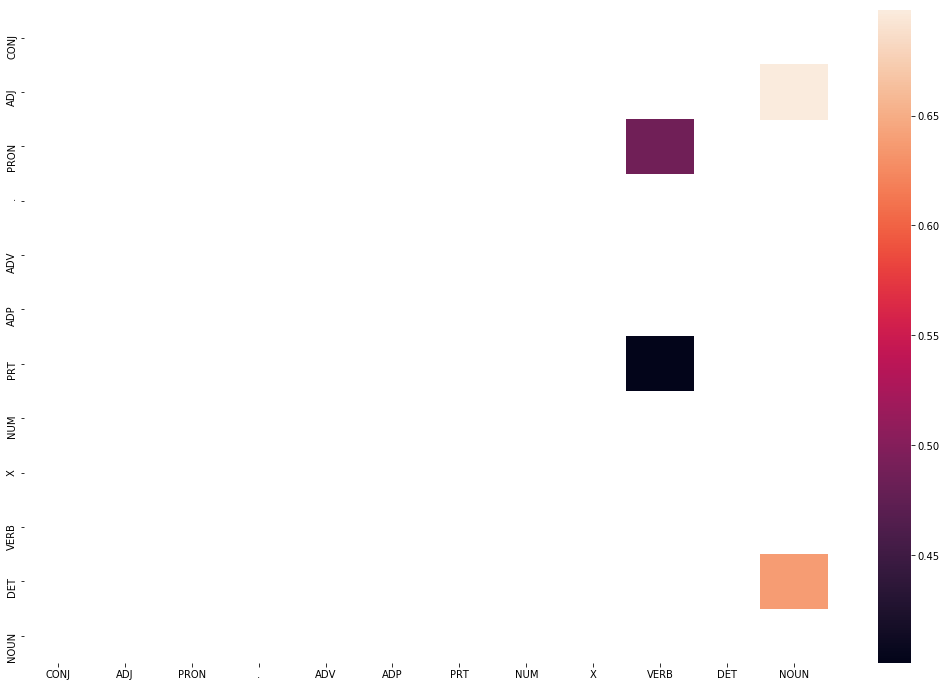

In [2407]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.4]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [2408]:
# Viterbi Heuristic
# This is the original Vitrebi algorithm
# Here Transitiona and Emission probabilities are calulated
# to predict the tag of the word
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [2409]:
## Evaluating on Test Set

In [2410]:
# # Let's test our Viterbi algorithm on a few sample sentences of test dataset
# random.seed(1234)

# # choose random 5 sents
# rndom = [random.randint(1,len(test_set)) for x in range(5)]

# rndom

In [2411]:
# list of sents
#test_sent = [test_set[i] for i in rndom]

# Lets run against full 5% test set split earlier
test_sent = test_set

# list of tagged words
test_tagged_words = [tup for sent in test_sent for tup in sent]

# list of test words/tokens
test_words = [tup[0] for tup in test_tagged_words]

In [2412]:
len(test_words)

5202

In [2413]:
# tagging the test sentences
start = time.time()
tagged_seq_v0 = Viterbi(test_words)
end = time.time()
duration_v0 = end-start

In [2414]:
print("v0: Time taken in seconds: ", duration_v0)

v0: Time taken in seconds:  578.724071264267


In [2415]:
tagged_seq_df_v0 = pd.DataFrame(tagged_seq_v0, columns=['word', 'pred_tag_v0'])

In [2416]:
tagged_seq_df_v0.head()

,word,pred_tag_v0
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2417]:
test_tagged_words_df = pd.DataFrame(test_tagged_words, columns=['word', 'actual_tag'])

In [2418]:
test_tagged_words_df.head()

,word,actual_tag
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2419]:
tagged_words_df = pd.concat([test_tagged_words_df, tagged_seq_df_v0[['pred_tag_v0']]], axis=1)

In [2420]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0
0,Index,NOUN,NOUN
1,arbitrage,NOUN,NOUN
2,is,VERB,VERB
3,a,DET,DET
4,common,ADJ,ADJ


In [2421]:
tagged_words_df.shape

(5202, 3)

In [2422]:
# Get the list of unknown words
unknown_words_test = [w for w in test_words if w not in tokens]

In [2423]:
tagged_words_df['unknown'] = tagged_words_df['word'].apply(lambda x : 0 if x not in unknown_words_test else 1)

In [2424]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0,unknown
0,Index,NOUN,NOUN,0
1,arbitrage,NOUN,NOUN,0
2,is,VERB,VERB,0
3,a,DET,DET,0
4,common,ADJ,ADJ,0


In [2425]:
# Lets' evaluate accuracy
tagged_correct_v0 = tagged_words_df[tagged_words_df['pred_tag_v0'] ==
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_correct_v0 .head()

,word,actual_tag,pred_tag_v0,unknown
0,Index,NOUN,NOUN,0
1,arbitrage,NOUN,NOUN,0
2,is,VERB,VERB,0
3,a,DET,DET,0
4,common,ADJ,ADJ,0


In [2426]:
accuracy_v0 = round((tagged_correct_v0.shape[0]/tagged_words_df.shape[0])*100, 2)
accuracy_v0

90.14

In [2427]:
tagged_incorrect_v0 = tagged_words_df[tagged_words_df['pred_tag_v0'] !=
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_incorrect_v0 .head()

,word,actual_tag,pred_tag_v0,unknown
0,South,ADJ,NOUN,0
1,African,ADJ,NOUN,0
2,chaotic,ADJ,CONJ,1
3,overvalued,VERB,CONJ,1
4,*T*-242,X,CONJ,1


In [2428]:
tagged_incorrect_unknowns_v0 = tagged_incorrect_v0[tagged_incorrect_v0['unknown'] == 1][['word','actual_tag','pred_tag_v0']].reset_index(drop=True)
tagged_incorrect_unknowns_v0.head()

,word,actual_tag,pred_tag_v0
0,chaotic,ADJ,CONJ
1,overvalued,VERB,CONJ
2,*T*-242,X,CONJ
3,ordering,VERB,CONJ
4,incentive-bonus,NOUN,CONJ


In [2429]:
tagged_correct_unknowns_v0 = tagged_correct_v0[tagged_correct_v0['unknown'] == 1][['word','actual_tag','pred_tag_v0']].reset_index(drop=True)
tagged_correct_unknowns_v0.head()

,word,actual_tag,pred_tag_v0


## Solve the problem of unknown words

### Technique 1 : Lexicon + Viterbi combined tagger

In [2430]:
unknown_words_test

['chaotic',
 'overvalued',
 '*T*-242',
 'ordering',
 'incentive-bonus',
 'cycles',
 'Michio',
 'Sasaki',
 'Keidanren',
 'Federation',
 'Organizations',
 'aspect',
 'two-time-losers',
 '*-29',
 'Lorenzo',
 '13.625',
 'Mannix',
 'sparking',
 'posing',
 'index-options',
 '*T*-70',
 'captivating',
 'disagreeable',
 'tired',
 'stigma',
 'campaigner',
 'Rozell',
 '361.8',
 'fetching',
 'Miles',
 'Barth',
 'Photography',
 'Goldinger',
 'Insight',
 '77.70',
 '77.56',
 'Appeals',
 'quietly',
 'tinker',
 '83,206',
 'tenfold',
 'injuring',
 'fiber',
 'resilient',
 'lungs',
 'symptoms',
 'enjoyed',
 'spectacular',
 'smoothly',
 "'86",
 'Opus',
 'Dominus',
 'designation',
 'generous',
 '1991-2000',
 'Certainly',
 '*T*-159',
 'prospectively',
 'Sauternes',
 'lighter',
 'spectacularly',
 'Furukawa',
 'Judging',
 'Haruki',
 '320',
 '18.95',
 'baby',
 'boomers',
 '*-102',
 '*-102',
 'Arbitraging',
 'built-from-kit',
 'Altair',
 'Sol',
 'IMSAI',
 'keyboards',
 'apologizing',
 'indulging',
 'shaping',
 '

In [2431]:
# Lets use below rules or patterns for identifying tags
tag_rules = [
    (r'.[a-zA-Z]+-[a-zA-Z]+', 'ADJ'),  # composite Adjectives
    (r'.*ing$', 'VERB'),               # gerund
    (r'.*ed$', 'VERB'),                # past tense    
    (r'.*\'s$', 'NOUN'),               # possessive nouns
    (r'.*s$', 'NOUN'),                 # plural nouns
    (r'^[A-Z][a-zA-Z]{3,}','NOUN'),    # Begin with Uppercase words,len> 4 as Nouns 
    (r'.*ly$', 'ADV'),                 # Adverbs
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),  # Numbers
]

In [2432]:
# This function will return the matched tag fo the provided word
# if a match is found, otherwise returns None i.e. no Tag

def find_rule_tag(word, pattern=tag_rules):
    regexp_tagger = RegexpTagger(pattern)
    result = regexp_tagger.tag(word)
    return(result[0][1])    

In [2433]:
wtag = find_rule_tag(["1hair"]) 
if wtag == None:
    print('Not found')
else:
    print(wtag)


Not found


In [2434]:
# Viterbi Heuristic + Lexicon Rule based tagger
# We will use the Rule based tagger as per function defined find_rule_tag
# to find tags for words which are not there is training word set and are
# therefore unknown.
# The whole algorithm is
#  if word not in training set
#      use find_rule_tag function 
#      if tag-not-found using find_rule_tag
#          use Maximum Trasition probablility
#  else
#      use maximum (Transition * Emission Probability)

def Viterbi_v1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    W = list(set([pair[0] for pair in train_bag]))

    for key, word in enumerate(words):
        # If word is an unknown word then use wword that are occcuring
        # with the given word i.e. the immediate word before and after
        # the given word to predict the tag of given word
        if word not in W:
            rule_tag = find_rule_tag([word])
            if rule_tag != None:
                state.append(rule_tag)
                # Iterate to the next word without calculating Transition
                # or emission probabilities
                continue

        # Now we know that word is a known word, let's calculate
        # Transition and Emmission Probabilities to predict tag
        
        # initialise list of probability column for a given observation
        p = [] 
            
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
        
            if word not in W:
                state_probability = transition_p 
                # Iterate to next tag as there will be no emission probablities
            else:    
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                        
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [2435]:
# tagging the test sentences
start = time.time()
tagged_seq_v1 = Viterbi_v1(test_words)
end = time.time()
duration_v1 = end-start

In [2436]:
print("v1 : Time taken in seconds: ", duration_v1)

v1 : Time taken in seconds:  566.9425859451294


In [2437]:
tagged_seq_df_v1 = pd.DataFrame(tagged_seq_v1, columns=['word', 'pred_tag_v1'])

In [2438]:
tagged_seq_df_v1.head()

,word,pred_tag_v1
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2439]:
test_tagged_words_df.head()

,word,actual_tag
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2440]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0,unknown
0,Index,NOUN,NOUN,0
1,arbitrage,NOUN,NOUN,0
2,is,VERB,VERB,0
3,a,DET,DET,0
4,common,ADJ,ADJ,0


In [2441]:
tagged_words_df = pd.concat([tagged_words_df, tagged_seq_df_v1[['pred_tag_v1']]], axis=1)

In [2442]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,Index,NOUN,NOUN,0,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN
2,is,VERB,VERB,0,VERB
3,a,DET,DET,0,DET
4,common,ADJ,ADJ,0,ADJ


In [2443]:
tagged_words_df.shape

(5202, 5)

In [2444]:
# Lets' evaluate accuracy
tagged_correct_v1 = tagged_words_df[tagged_words_df['pred_tag_v1'] ==
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_correct_v1 .head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,Index,NOUN,NOUN,0,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN
2,is,VERB,VERB,0,VERB
3,a,DET,DET,0,DET
4,common,ADJ,ADJ,0,ADJ


In [2445]:
accuracy_v1 = round((tagged_correct_v1.shape[0]/tagged_words_df.shape[0])*100, 2)
accuracy_v1

95.54

In [2446]:
tagged_incorrect_v1 = tagged_words_df[tagged_words_df['pred_tag_v1'] !=
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_incorrect_v1 .head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,South,ADJ,NOUN,0,NOUN
1,African,ADJ,NOUN,0,NOUN
2,chaotic,ADJ,CONJ,1,NOUN
3,*T*-242,X,CONJ,1,VERB
4,incentive-bonus,NOUN,CONJ,1,ADJ


In [2447]:
tagged_incorrect_unknowns_v1 = tagged_incorrect_v1[tagged_incorrect_v1['unknown'] == 1][['word','actual_tag','pred_tag_v1']].reset_index(drop=True)
tagged_incorrect_unknowns_v1.head()

,word,actual_tag,pred_tag_v1
0,chaotic,ADJ,NOUN
1,*T*-242,X,VERB
2,incentive-bonus,NOUN,ADJ
3,index-options,NOUN,ADJ
4,*T*-70,X,DET


In [2448]:
tagged_correct_unknowns_v1 = tagged_correct_v1[tagged_correct_v1['unknown'] == 1][['word','actual_tag','pred_tag_v1']].reset_index(drop=True)
tagged_correct_unknowns_v1.head()

,word,actual_tag,pred_tag_v1
0,overvalued,VERB,VERB
1,ordering,VERB,VERB
2,cycles,NOUN,NOUN
3,Michio,NOUN,NOUN
4,Sasaki,NOUN,NOUN


#### Evaluating tagging accuracy

In [2449]:
accuracy_v1 = round((tagged_correct_v1.shape[0]/tagged_words_df.shape[0])*100, 2)

In [2450]:
accuracy_v1

95.54

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [2451]:
tag_pred_model_v0 = "Vitrebi Default v0"
num_test_words = tagged_words_df.shape[0]
num_unknown_words = len(unknown_words_test)
correct_pred_v0 = tagged_correct_v0.shape[0]
incorrect_pred_v0 = tagged_incorrect_v0.shape[0]
correct_unknowns_pred_v0 = tagged_correct_unknowns_v0.shape[0]
incorrect_unknowns_pred_v0 = tagged_incorrect_unknowns_v0.shape[0]
accuracy_tag_pred_v0 = accuracy_v0
time_to_run_v0 = duration_v0 


stats_v0 = [accuracy_v0, time_to_run_v0, num_test_words, correct_pred_v0, 
            incorrect_pred_v0, num_unknown_words, correct_unknowns_pred_v0,
            incorrect_unknowns_pred_v0]

In [2452]:
stats_data = [stats_v0]

In [2453]:
stats_index = [tag_pred_model_v0]

In [2454]:
stats_columns = ["accuracy", "time_to_run", "num_test_words", "correct_pred",
                 "incorrect_pred", "num_unknown_words", "correct_unknowns_pred",
                 "incorrect_unknowns_pred"] 

In [2455]:
tagged_words_accuracy = pd.DataFrame(stats_data, 
                                     columns=stats_columns, 
                                     index=stats_index)


In [2456]:
tagged_words_accuracy

,accuracy,time_to_run,num_test_words,correct_pred,incorrect_pred,num_unknown_words,correct_unknowns_pred,incorrect_unknowns_pred
Vitrebi Default v0,90.14,578.724071,5202,4689,513,361,0,361


In [2457]:
tag_pred_model_v1 = "Vitrebi + Lexicon v1"
correct_pred_v1 = tagged_correct_v1.shape[0]
incorrect_pred_v1 = tagged_incorrect_v1.shape[0]
correct_unknowns_pred_v1 = tagged_correct_unknowns_v1.shape[0]
incorrect_unknowns_pred_v1 = tagged_incorrect_unknowns_v1.shape[0]
accuracy_tag_pred = accuracy_v1
time_to_run_v1 = duration_v1 

stats_v1 = [accuracy_v1, time_to_run_v1, num_test_words, correct_pred_v1,
            incorrect_pred_v1, num_unknown_words, correct_unknowns_pred_v1,
            incorrect_unknowns_pred_v1]

In [2458]:
tagged_words_accuracy = tagged_words_accuracy.append(pd.Series
                                                     (stats_v1,
                                                      index=stats_columns, 
                                                      name=tag_pred_model_v1))

In [2459]:
tagged_words_accuracy

,accuracy,time_to_run,num_test_words,correct_pred,incorrect_pred,num_unknown_words,correct_unknowns_pred,incorrect_unknowns_pred
Vitrebi Default v0,90.14,578.724071,5202.0,4689.0,513.0,361.0,0.0,361.0
Vitrebi + Lexicon v1,95.54,566.942586,5202.0,4970.0,232.0,361.0,277.0,84.0


In [2460]:
accuracy_v1 = round((tagged_correct_v1.shape[0]/tagged_words_df.shape[0])*100, 2)
accuracy_v1

95.54

In [2461]:
print("Accuracy Vitrebi default    : V0   = ", accuracy_v0)
print("Accuracy Vitrebi + Co-Words : V1   = ", accuracy_v1)

Accuracy Vitrebi default    : V0   =  90.14
Accuracy Vitrebi + Co-Words : V1   =  95.54


In [2462]:
tagging_gain_percent = round((accuracy_v1 - accuracy_v0), 2)

In [2463]:
print("Accuracy Gain: V1-V0 =", tagging_gain_percent)

Accuracy Gain: V1-V0 = 5.4


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [2464]:
tagged_incorrect_v0

,word,actual_tag,pred_tag_v0,unknown
0,South,ADJ,NOUN,0
1,African,ADJ,NOUN,0
2,chaotic,ADJ,CONJ,1
3,overvalued,VERB,CONJ,1
4,*T*-242,X,CONJ,1
5,ordering,VERB,CONJ,1
6,incentive-bonus,NOUN,CONJ,1
7,buffet,VERB,NOUN,0
8,cycles,NOUN,CONJ,1
9,Michio,NOUN,CONJ,1


In [2465]:
tagged_correct_v1.head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,Index,NOUN,NOUN,0,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN
2,is,VERB,VERB,0,VERB
3,a,DET,DET,0,DET
4,common,ADJ,ADJ,0,ADJ


In [2466]:
pd.merge(tagged_incorrect_v0,tagged_correct_v1, how='inner', on=['word','actual_tag', 'pred_tag_v0', 'unknown'] )

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,overvalued,VERB,CONJ,1,VERB
1,ordering,VERB,CONJ,1,VERB
2,cycles,NOUN,CONJ,1,NOUN
3,Michio,NOUN,CONJ,1,NOUN
4,Sasaki,NOUN,CONJ,1,NOUN
5,Keidanren,NOUN,CONJ,1,NOUN
6,Federation,NOUN,CONJ,1,NOUN
7,Organizations,NOUN,CONJ,1,NOUN
8,aspect,NOUN,CONJ,1,NOUN
9,two-time-losers,ADJ,CONJ,1,ADJ


### Technique 2 : Viterbi + Frequent co-occuring word tagger

In [2467]:
from collections import Counter

In [2469]:
# Tagging based on frequent co-occuring word tags
def freq_coword_tag(words, key, train_bag = train_tagged_words):
    # Looking for word just before and after the given word 
    # whose tag is to be predicted. Co-occuring words.
    # <pre-word><given-word><post-word>
    # find all words of type
    #  <pre-word>[word1, word2, ] = pre_next_words 
    #  <pre-word>[tag_word1, tag_word2,...] = pre_next_tags
    
    #  [word1, word2,...]<post-word> = list of words before post-word
    #  [tag_word1, tag_word2,...]<post-word> = list of tags before post-word tag
    
    #  freq_tag = most_frequent_tag[pre_word_tags + post_prev_tags]
    #  Note if no tag is found then as a default NOUN tag is returned
           
    pre_word = ""
    post_word = ""
    
    if key > 0:
        pre_word = words[key-1]
    if key < len(words)-1:
        post_word = words[key+1]

    # Analysing Tags of all the words that follow the immediate word 
    # preceding the given word 
    # 

    pre_next_words = []
    pre_next_tags  = []

    if len(pre_word) > 1:
        pre_next_words =  [train_bag[i+1]
                           for i, tup in enumerate(train_bag)
                           if (i < (len(train_bag)-1) and
                               tup[0].lower() == pre_word.lower() 
                              )
                           ]

        pre_next_tags = [pair[1] for pair in pre_next_words]
        if len(pre_next_tags) > 0:
            pre_tag_max = Counter(pre_next_tags).most_common(1)[0][0]
    
            
    # Analysing Tags of all the words that precede the immediate word 
    # following the given word 
    
    post_prev_words = []
    post_prev_tags = []

    if len(post_word) > 1:
        post_prev_words =  [train_bag[i-1] 
                            for i, tup in enumerate(train_bag)
                            if (i > 0 and
                                tup[0].lower() == post_word.lower()
                               )
                            ]

        post_prev_tags = [pair[1] for pair in post_prev_words]                
        if len(post_prev_tags) > 0:        
            post_tag_max = Counter(post_prev_tags).most_common(1)[0][0]
    
    pre_post_all_tags = pre_next_tags + post_prev_tags
    
    # Using NOUN as default tag
    pre_post_all_tags_max = "NOUN"    
       
    if len(pre_post_all_tags) > 0:
        pre_post_all_tags_max = Counter(pre_post_all_tags).most_common(1)[0][0]

    return(pre_post_all_tags_max)            

In [2476]:
### Viterbi Heuristic + Pattern + co-occuring words based tagger
# We will use some patters and the co-occuring words based tagger 
# as per function defined freq_coword_tag to find tags for words 
# which are not there in the training word set and are therefore unknown.

### The whole algorithm is
#  if word not in training set
#      use patterns to identify numbers, hyphenated adjectives, uppercase words
#  else  
#      use freq_coword_tag function to find tag
#  else
#      use maximum (Transition * Emission Probability)

def Viterbi_v2(words, train_bag = train_tagged_words):
    state = []
    T = []
    W = []
    
    T = list(set([pair[1] for pair in train_bag]))
    W = list(set([pair[0] for pair in train_bag]))

    for key, word in enumerate(words):
        # If word is an unknown word then use wword that are occcuring
        # with the given word i.e. the immediate word before and after
        # the given word to predict the tag of given word
        if word not in W:           
            # Let's use co-occuring words tagging method
            freq_tag = freq_coword_tag(words, key)
            state.append(freq_tag)             
                        
            # Iterate to the next word without calculating Tranistion
            # or emission probabilities
            continue

        # Now we know that word is a known word, let's calculate
        # Transition and Emmission Probabilities to predict tag
        #initialise list of probability column for a given observation
        p = [] 

        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities

            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    

            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    
    return list(zip(words, state))


In [2477]:
# tagging the test sentences
start = time.time()
tagged_seq_v2 = Viterbi_v2(test_words)
end = time.time()
duration_v2 = end-start

In [2478]:
print("v2: Viterbi Time taken in seconds: ", duration_v2)

v2: Viterbi Time taken in seconds:  553.9772601127625


In [2479]:
tagged_seq_df_v2 = pd.DataFrame(tagged_seq_v2, columns=['word', 'pred_tag_v2']) 

In [2480]:
tagged_seq_df_v2.head()

,word,pred_tag_v2
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2481]:
test_tagged_words_df.head()

,word,actual_tag
0,Index,NOUN
1,arbitrage,NOUN
2,is,VERB
3,a,DET
4,common,ADJ


In [2482]:
#tagged_words_df.drop(columns =['pred_tag_v2'], axis=1, inplace=True)

In [2483]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1
0,Index,NOUN,NOUN,0,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN
2,is,VERB,VERB,0,VERB
3,a,DET,DET,0,DET
4,common,ADJ,ADJ,0,ADJ


In [2484]:
tagged_words_df = pd.concat([tagged_words_df, tagged_seq_df_v2[['pred_tag_v2']]], axis=1)

In [2485]:
tagged_words_df.head()

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1,pred_tag_v2
0,Index,NOUN,NOUN,0,NOUN,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN,NOUN
2,is,VERB,VERB,0,VERB,VERB
3,a,DET,DET,0,DET,DET
4,common,ADJ,ADJ,0,ADJ,ADJ


In [2486]:
tagged_words_df.shape

(5202, 6)

In [2487]:
# Lets' evaluate accuracy
tagged_correct_v2 = tagged_words_df[tagged_words_df['pred_tag_v2'] ==
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_correct_v2 .head(100)

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1,pred_tag_v2
0,Index,NOUN,NOUN,0,NOUN,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN,NOUN
2,is,VERB,VERB,0,VERB,VERB
3,a,DET,DET,0,DET,DET
4,common,ADJ,ADJ,0,ADJ,ADJ
5,form,NOUN,NOUN,0,NOUN,NOUN
6,of,ADP,ADP,0,ADP,ADP
7,program,NOUN,NOUN,0,NOUN,NOUN
8,trading,NOUN,NOUN,0,NOUN,NOUN
9,.,.,.,0,.,.


In [2488]:
tagged_correct_v2 .head(100)

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1,pred_tag_v2
0,Index,NOUN,NOUN,0,NOUN,NOUN
1,arbitrage,NOUN,NOUN,0,NOUN,NOUN
2,is,VERB,VERB,0,VERB,VERB
3,a,DET,DET,0,DET,DET
4,common,ADJ,ADJ,0,ADJ,ADJ
5,form,NOUN,NOUN,0,NOUN,NOUN
6,of,ADP,ADP,0,ADP,ADP
7,program,NOUN,NOUN,0,NOUN,NOUN
8,trading,NOUN,NOUN,0,NOUN,NOUN
9,.,.,.,0,.,.


In [2489]:
tagged_incorrect_v2 = tagged_words_df[tagged_words_df['pred_tag_v2'] !=
                                         tagged_words_df['actual_tag']
                                        ].reset_index(drop=True)
tagged_incorrect_v2 .head(50)

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1,pred_tag_v2
0,South,ADJ,NOUN,0,NOUN,NOUN
1,African,ADJ,NOUN,0,NOUN,NOUN
2,chaotic,ADJ,CONJ,1,NOUN,ADP
3,overvalued,VERB,CONJ,1,VERB,NOUN
4,*T*-242,X,CONJ,1,VERB,NOUN
5,ordering,VERB,CONJ,1,VERB,ADP
6,buffet,VERB,NOUN,0,NOUN,NOUN
7,Michio,NOUN,CONJ,1,NOUN,VERB
8,Keidanren,NOUN,CONJ,1,NOUN,DET
9,two-time-losers,ADJ,CONJ,1,ADJ,.


In [2490]:
tagged_incorrect_unknowns_v2 = tagged_incorrect_v2[tagged_incorrect_v2['unknown'] == 1][['word','actual_tag','pred_tag_v2']].reset_index(drop=True)
tagged_incorrect_unknowns_v2.head()

,word,actual_tag,pred_tag_v2
0,chaotic,ADJ,ADP
1,overvalued,VERB,NOUN
2,*T*-242,X,NOUN
3,ordering,VERB,ADP
4,Michio,NOUN,VERB


In [2491]:
tagged_correct_unknowns_v2 = tagged_correct_v2[tagged_correct_v2['unknown'] == 1][['word','actual_tag','pred_tag_v2']].reset_index(drop=True)
tagged_correct_unknowns_v2.head()

,word,actual_tag,pred_tag_v2
0,incentive-bonus,NOUN,NOUN
1,cycles,NOUN,NOUN
2,Sasaki,NOUN,NOUN
3,Federation,NOUN,NOUN
4,Organizations,NOUN,NOUN


#### Evaluating tagging accuracy

In [2492]:
accuracy_v2 = round((tagged_correct_v2.shape[0]/tagged_words_df.shape[0])*100, 2)

In [2493]:
accuracy_v2

94.04

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [2494]:
tag_pred_model_v2 = "Vitrebi + Frequent Co-word v2"
correct_pred_v2 = tagged_correct_v2.shape[0]
incorrect_pred_v2 = tagged_incorrect_v2.shape[0]
correct_unknowns_pred_v2 = tagged_correct_unknowns_v2.shape[0]
incorrect_unknowns_pred_v2 = tagged_incorrect_unknowns_v2.shape[0]
accuracy_tag_pred = accuracy_v2
time_to_run_v2 = duration_v2 

stats_v2 = [accuracy_v2, time_to_run_v2, num_test_words, correct_pred_v2,
            incorrect_pred_v2, num_unknown_words, correct_unknowns_pred_v2,
            incorrect_unknowns_pred_v2]

In [2495]:
tagged_words_accuracy = tagged_words_accuracy.append(pd.Series
                                                     (stats_v2,
                                                      index=stats_columns, 
                                                      name=tag_pred_model_v2))

In [2496]:
tagged_words_accuracy

,accuracy,time_to_run,num_test_words,correct_pred,incorrect_pred,num_unknown_words,correct_unknowns_pred,incorrect_unknowns_pred
Vitrebi Default v0,90.14,578.724071,5202.0,4689.0,513.0,361.0,0.0,361.0
Vitrebi + Lexicon v1,95.54,566.942586,5202.0,4970.0,232.0,361.0,277.0,84.0
Vitrebi + Frequent Co-word v2,94.04,553.977260,5202.0,4892.0,310.0,361.0,201.0,160.0


In [2497]:
print("Accuracy Vitrebi default    : V0   = ", accuracy_v0)
print("Accuracy Vitrebi + Co-Words : V2   = ", accuracy_v2)

Accuracy Vitrebi default    : V0   =  90.14
Accuracy Vitrebi + Co-Words : V2   =  94.04


In [2498]:
tagging_gain_percent = round((accuracy_v2 - accuracy_v0), 2)

In [2499]:
print("Accuracy Gain: V2-V0 =", tagging_gain_percent)

Accuracy Gain: V2-V0 = 3.9


##### Well model v1 i.e. (Vitrebi + Lexicon) performance is better than the Original v0 (Vitrebi) and V2 (Vitrebi+ Frequent Co-word).

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [2500]:
incorrect_tagged_v0 

,word,tag_actual,tag_predicted_V0
0,either,DET,CONJ
1,*-112,X,CONJ
2,that,ADP,DET
3,bid,NOUN,VERB
4,Great,ADJ,NOUN
5,evaporated,VERB,CONJ


In [2501]:
incorrect_tagged_v2 

,word,tag_actual,tag_predicted_v2
0,either,DET,CONJ
1,*-112,X,NOUN
2,bid,NOUN,VERB
3,Great,ADJ,NOUN


In [2502]:
pd.merge(tagged_incorrect_v0,tagged_correct_v2, how='inner', on=['word','actual_tag', 'pred_tag_v0', 'unknown'] )

,word,actual_tag,pred_tag_v0,unknown,pred_tag_v1,pred_tag_v2
0,incentive-bonus,NOUN,CONJ,1,ADJ,NOUN
1,cycles,NOUN,CONJ,1,NOUN,NOUN
2,Sasaki,NOUN,CONJ,1,NOUN,NOUN
3,Federation,NOUN,CONJ,1,NOUN,NOUN
4,Organizations,NOUN,CONJ,1,NOUN,NOUN
5,aspect,NOUN,CONJ,1,NOUN,NOUN
6,*-29,X,CONJ,1,X,X
7,*-29,X,CONJ,1,X,X
8,Lorenzo,NOUN,CONJ,1,NOUN,NOUN
9,13.625,NUM,CONJ,1,NUM,NUM


### Final testing with external File - Test_sentences

In [2503]:
# Let's read file with test sentences
test_file = open(folder/'Test_sentences.txt', 'r')

# Let's read all the text in the file
text_in_file = test_file.read()

# Extract all words
words_in_file = word_tokenize(text_in_file)

In [2504]:
# tagging the test sentences using Vitrebi2 model
start = time.time()
tagged_seq_file_v2 = Viterbi_v2(words_in_file)
end = time.time()
duration_test_file_v2 = end-start

In [2505]:
print("V2 Test File : Viterbi Time taken in seconds: ", duration_test_file_v2 )

V2 Test File : Viterbi Time taken in seconds:  17.509166955947876


In [2506]:
tagged_file_v2 = pd.DataFrame(tagged_seq_file, columns=['word', 'pred_tag_v2'])

In [2507]:
tagged_file_v2.head()

,word,pred_tag_v2
0,Android,NOUN
1,is,VERB
2,a,DET
3,mobile,ADJ
4,operating,NOUN


In [2508]:
# Get the list of unknown words in file
file_unknown_words = [w for w in words_in_file if w not in tokens]

In [2509]:
tagged_file_v2['unknown'] = tagged_file_v2['word'].apply(lambda x : 0 if x not in file_unknown_words else 1)

In [2510]:
# tagging the test sentences using Vitrebi2 model
start = time.time()
tagged_seq_file_v1 = Viterbi_v1(words_in_file)
end = time.time()
duration_test_file_v1 = end-start

In [2511]:
print("V1 Test File : Viterbi Time taken in seconds: ", duration_test_file_v1)

V1 Test File : Viterbi Time taken in seconds:  16.479919910430908


In [2512]:
tagged_file_v1 = pd.DataFrame(tagged_seq_file_v1, columns=['word', 'pred_tag_v1'])

In [2513]:
tagged_file_v1['unknown'] = tagged_file_v1['word'].apply(lambda x : 0 if x not in file_unknown_words else 1)

In [2514]:
tagged_file = pd.concat([tagged_file_v2, tagged_file_v1[['pred_tag_v1']]], axis=1)

In [2515]:
tagged_file.head()

,word,pred_tag_v2,unknown,pred_tag_v1
0,Android,NOUN,1,NOUN
1,is,VERB,0,VERB
2,a,DET,0,DET
3,mobile,ADJ,0,ADJ
4,operating,NOUN,0,NOUN


In [2516]:
tagged_file_diff_v1_v2 = tagged_file[tagged_file['pred_tag_v1'] != tagged_file['pred_tag_v2']].reset_index(drop=True)
tagged_file_diff_v1_v2 

,word,pred_tag_v2,unknown,pred_tag_v1
0,smartphones,DET,1,NOUN
1,2011,NOUN,1,NUM
2,2013,NOUN,1,NUM
3,2015,NOUN,1,NUM
4,Google,ADJ,1,NOUN
5,Twitter,VERB,1,NOUN
6,firehose,NOUN,1,VERB
7,messages,DET,1,NOUN
8,domineering,NOUN,1,VERB
9,2018,NOUN,1,NUM


In [2517]:
tagged_file_unknowns = tagged_file[tagged_file['unknown'] == 1].reset_index(drop=True)
tagged_file_unknowns.head()

,word,pred_tag_v2,unknown,pred_tag_v1
0,Android,NOUN,1,NOUN
1,Google,NOUN,1,NOUN
2,Android,NOUN,1,NOUN
3,OS,NOUN,1,NOUN
4,worldwide,NOUN,1,NOUN


In [2518]:
tagged_file_unknown_diff_v1_v2 = tagged_file_unknowns[tagged_file_unknowns['pred_tag_v1'] != tagged_file_unknowns['pred_tag_v2']].reset_index(drop=True)
tagged_file_unknown_diff_v1_v2 

,word,pred_tag_v2,unknown,pred_tag_v1
0,smartphones,DET,1,NOUN
1,2011,NOUN,1,NUM
2,2013,NOUN,1,NUM
3,2015,NOUN,1,NUM
4,Google,ADJ,1,NOUN
5,Twitter,VERB,1,NOUN
6,firehose,NOUN,1,VERB
7,messages,DET,1,NOUN
8,domineering,NOUN,1,VERB
9,2018,NOUN,1,NUM


In [2519]:
Matching_tag_percent_v1_v2 = round(100 - (tagged_file_diff_v1_v2.shape[0]/tagged_file.shape[0]) * 100, 2)
Matching_tag_percent_v1_v2

91.16

##### Around 91.6% of values are predicted same by either models V1(Vitrebi + Lexicon) and V2(Vitrebi + Frequent Co-word)

### However, looking at prediction of unknown words, model V1(Vitrebi + Lexicon) seems to perform better. 

In [2521]:
# tagging the test sentences using Vitrebi2 model
start = time.time()
tagged_seq_file_v0 = Viterbi(words_in_file)
end = time.time()
duration_test_file_v0 = end-start

In [2522]:
print("V0 Test File : Viterbi Time taken in seconds: ", duration_test_file_v0)

V0 Test File : Viterbi Time taken in seconds:  19.96260643005371


In [2523]:
tagged_file_v0 = pd.DataFrame(tagged_seq_file_v0, columns=['word', 'pred_tag_v0'])

In [2524]:
tagged_file_v0['unknown'] = tagged_file_v0['word'].apply(lambda x : 0 if x not in file_unknown_words else 1)

In [2525]:
tagged_file_v0_v1 = pd.concat([tagged_file_v0, tagged_file_v1[['pred_tag_v1']]], axis=1)

In [2526]:
tagged_file_v0_v1.head()

,word,pred_tag_v0,unknown,pred_tag_v1
0,Android,CONJ,1,NOUN
1,is,VERB,0,VERB
2,a,DET,0,DET
3,mobile,ADJ,0,ADJ
4,operating,NOUN,0,NOUN


In [2528]:
tagged_file_diff_v0_v1 = tagged_file_v0_v1[tagged_file_v0_v1['pred_tag_v0'] != tagged_file['pred_tag_v1']].reset_index(drop=True)
tagged_file_diff_v0_v1 

,word,pred_tag_v0,unknown,pred_tag_v1
0,Android,CONJ,1,NOUN
1,Google,CONJ,1,NOUN
2,Android,CONJ,1,NOUN
3,OS,CONJ,1,NOUN
4,worldwide,CONJ,1,NOUN
5,smartphones,CONJ,1,NOUN
6,2011,CONJ,1,NUM
7,2013,CONJ,1,NUM
8,Google,CONJ,1,NOUN
9,Twitter,CONJ,1,NOUN


In [2530]:
tagged_file_unknowns_v0_v1 = tagged_file_v0_v1[tagged_file_v0_v1['unknown'] == 1].reset_index(drop=True)
tagged_file_unknowns_v0_v1.head(10)

,word,pred_tag_v0,unknown,pred_tag_v1
0,Android,CONJ,1,NOUN
1,Google,CONJ,1,NOUN
2,Android,CONJ,1,NOUN
3,OS,CONJ,1,NOUN
4,worldwide,CONJ,1,NOUN
5,smartphones,CONJ,1,NOUN
6,2011,CONJ,1,NUM
7,2013,CONJ,1,NUM
8,Google,CONJ,1,NOUN
9,Twitter,CONJ,1,NOUN


In [2531]:
tagged_file_unknown_diff_v0_v1 = tagged_file_unknowns_v0_v1[tagged_file_unknowns_v0_v1['pred_tag_v0'] != tagged_file_unknowns['pred_tag_v1']].reset_index(drop=True)
tagged_file_unknown_diff_v0_v1 

,word,pred_tag_v0,unknown,pred_tag_v1
0,Android,CONJ,1,NOUN
1,Google,CONJ,1,NOUN
2,Android,CONJ,1,NOUN
3,OS,CONJ,1,NOUN
4,worldwide,CONJ,1,NOUN
5,smartphones,CONJ,1,NOUN
6,2011,CONJ,1,NUM
7,2013,CONJ,1,NUM
8,Google,CONJ,1,NOUN
9,Twitter,CONJ,1,NOUN


In [2532]:
Matching_tag_percent_v0_v1 = round(100 - (tagged_file_diff_v0_v1.shape[0]/tagged_file_v0_v1.shape[0]) * 100, 2)
Matching_tag_percent_v0_v1

79.01

### Prediction of words corrected for unknown words using Vitrebi + Lexicon tagger
    Andorid, Google, OS as NOUN
    2011, 2013, 2015 as NUM 
    contested, invited as VERB 


##### The V1(Vitrebi + Lexicon) predicts around 21% tags differently than Original V0 (Vitrebi)

### Looking at the rpediction of unknowns clearly  V1(Vitrebi + Lexicon)  performance is much better. 

In [2533]:
# Accuarcy table for Test data (used for validation earlier)
tagged_words_accuracy

,accuracy,time_to_run,num_test_words,correct_pred,incorrect_pred,num_unknown_words,correct_unknowns_pred,incorrect_unknowns_pred
Vitrebi Default v0,90.14,578.724071,5202.0,4689.0,513.0,361.0,0.0,361.0
Vitrebi + Lexicon v1,95.54,566.942586,5202.0,4970.0,232.0,361.0,277.0,84.0
Vitrebi + Frequent Co-word v2,94.04,553.977260,5202.0,4892.0,310.0,361.0,201.0,160.0
